In [13]:
import numpy as np
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [14]:
def get_folder_files(folder):
    files_cnt = 0
    for sub_folder in os.listdir(folder):
        print(folder, sub_folder)
        path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
        files_cnt += len(files)
    return files_cnt

In [33]:
train_data_dir = "images/train_f"
validation_data_dir = "images/test_f"

files_train = get_folder_files(train_data_dir)
files_validation = get_folder_files(validation_data_dir)

print(files_train, files_validation)

images/train_f nonparkinglot
images/train_f parkinglot
images/test_f nonparkinglot
images/test_f parkinglot
30 30


2 7


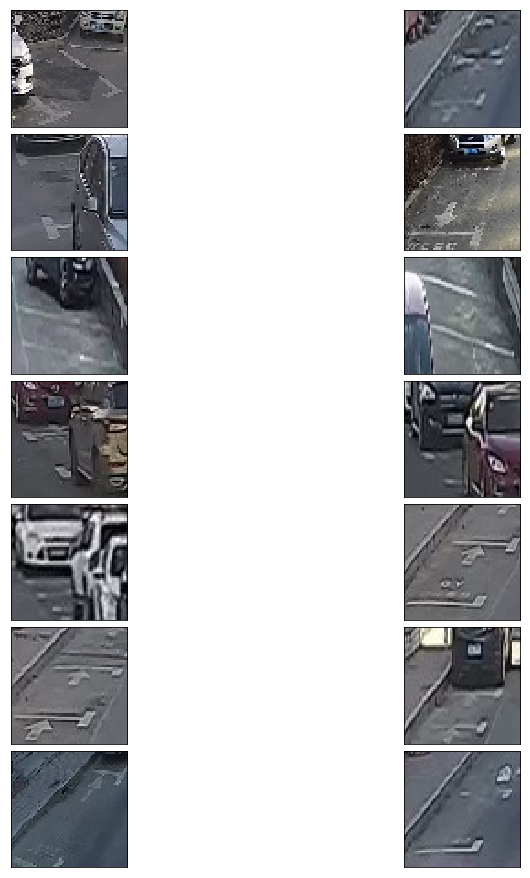

2 8


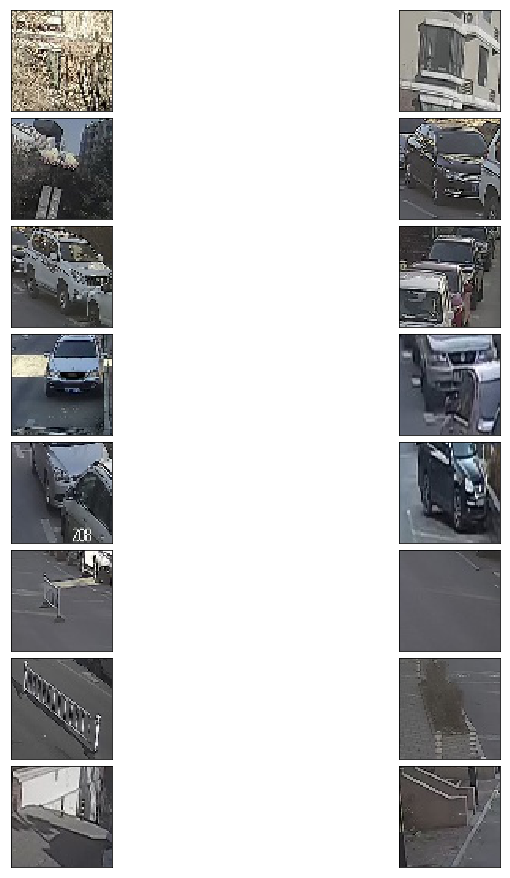

In [34]:
import matplotlib.pyplot as plt
import glob

def show_images(images, cmap=None):
    cols = 2
    rows = (len(images) + 1)//cols
    
    print(cols, rows)
    
    plt.figure(figsize=(15, 12))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    

parkinglot_images = [plt.imread(path) for path in glob.glob("images/train_f/parkinglot/*")]
nonparkinglot_images = [plt.imread(path) for path in glob.glob("images/train_f/nonparkinglot/*")]
show_images(parkinglot_images)
show_images(nonparkinglot_images)


In [35]:
img_width, img_height = 64, 64

nb_train_samples = files_train
nb_validation_samples = files_validation

batch_size = 2
epochs = 15
num_classes = 2

print(nb_train_samples, nb_validation_samples)

30 30


In [36]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

for layer in model.layers[:10]:
    layer.trainable = False

In [37]:
x = model.output
x = Flatten()(x)

predictions = Dense(num_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9), 
                    metrics = ["accuracy"])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [38]:
def gen_image_generator(data_dir):
    data_gen = ImageDataGenerator(
        rescale = 1. / 255,
        fill_mode = "nearest",
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range=0.1,
        rotation_range=5)
    
    image_generator = data_gen.flow_from_directory(
        data_dir,
        target_size = (img_height, img_width),
        batch_size = batch_size,
        class_mode = "categorical")
    
    return image_generator

In [39]:
train_generator = gen_image_generator(train_data_dir)
validation_generator = gen_image_generator(validation_data_dir)

Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [40]:
checkpoint = ModelCheckpoint("parking-lot.h5", monitor='val_acc', 
                             verbose=1, save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [41]:
history_object = model_final.fit_generator(
    train_generator, 
    samples_per_epoch = nb_train_samples,
    validation_data = validation_generator,
    nb_val_samples = nb_validation_samples,
    epochs = epochs,
    callbacks = [checkpoint, early])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., epochs=15, callbacks=[<keras.ca..., steps_per_epoch=15, validation_steps=30)`
  import sys


Epoch 1/15
15/15 [==============================] - 4s 262ms/step - loss: 0.9225 - acc: 0.4000 - val_loss: 0.5303 - val_acc: 0.8167

Epoch 00001: val_acc improved from -inf to 0.81667, saving model to parking-lot.h5
Epoch 2/15
15/15 [==============================] - 4s 235ms/step - loss: 0.5267 - acc: 0.7667 - val_loss: 0.4222 - val_acc: 0.9000

Epoch 00002: val_acc improved from 0.81667 to 0.90000, saving model to parking-lot.h5
Epoch 3/15
15/15 [==============================] - 4s 255ms/step - loss: 0.4038 - acc: 0.9667 - val_loss: 0.3045 - val_acc: 0.9833

Epoch 00003: val_acc improved from 0.90000 to 0.98333, saving model to parking-lot.h5
Epoch 4/15
15/15 [==============================] - 4s 261ms/step - loss: 0.2969 - acc: 0.9667 - val_loss: 0.2221 - val_acc: 1.0000

Epoch 00004: val_acc improved from 0.98333 to 1.00000, saving model to parking-lot.h5
Epoch 5/15
15/15 [==============================] - 4s 281ms/step - loss: 0.2000 - acc: 1.0000 - val_loss: 0.1630 - val_acc: 0.

In [80]:
print(model_final)

class_dictionary = {}
class_dictionary[0] = 'nonparkinglot'
class_dictionary[1] = 'parkinglot'


In [81]:
import glob
import cv2

def predit_images(test_dir):
    for path in glob.glob(test_dir):
        img = cv2.imread(path) / 255.0
        img = cv2.resize(img, dsize = (img_width, img_height), interpolation = cv2.INTER_CUBIC)
        img = np.expand_dims(img, axis=0)
        prediction = model_final.predict(img)
        label_index = np.argmax(prediction[0])
        print(path + " ===> " + class_dictionary[label_index])

In [87]:
predit_images('images/test/parkinglot/*')

images/test/parkinglot/parkinglot-1.jpg ===> parkinglot
images/test/parkinglot/parkinglot-10.jpg ===> parkinglot
images/test/parkinglot/parkinglot-11.jpg ===> parkinglot
images/test/parkinglot/parkinglot-12.jpg ===> parkinglot
images/test/parkinglot/parkinglot-13.jpg ===> parkinglot
images/test/parkinglot/parkinglot-14.jpg ===> parkinglot
images/test/parkinglot/parkinglot-2.jpg ===> parkinglot
images/test/parkinglot/parkinglot-3.jpg ===> parkinglot
images/test/parkinglot/parkinglot-4.jpg ===> parkinglot
images/test/parkinglot/parkinglot-5.jpg ===> parkinglot
images/test/parkinglot/parkinglot-6.jpg ===> parkinglot
images/test/parkinglot/parkinglot-7.jpg ===> parkinglot
images/test/parkinglot/parkinglot-8.jpg ===> parkinglot
images/test/parkinglot/parkinglot-9.jpg ===> parkinglot


In [84]:
predit_images('images/test/nonparkinglot/*')

images/test/nonparkinglot/building1.jpg ===> nonparkinglot
images/test/nonparkinglot/building2.jpg ===> nonparkinglot
images/test/nonparkinglot/building3.jpg ===> nonparkinglot
images/test/nonparkinglot/car1.jpg ===> nonparkinglot
images/test/nonparkinglot/car2.jpg ===> nonparkinglot
images/test/nonparkinglot/car3.jpg ===> nonparkinglot
images/test/nonparkinglot/car4.jpg ===> nonparkinglot
images/test/nonparkinglot/car5.jpg ===> nonparkinglot
images/test/nonparkinglot/car6.jpg ===> nonparkinglot
images/test/nonparkinglot/car7.jpg ===> nonparkinglot
images/test/nonparkinglot/ground1.jpg ===> nonparkinglot
images/test/nonparkinglot/ground2.jpg ===> nonparkinglot
images/test/nonparkinglot/ground3.jpg ===> nonparkinglot
images/test/nonparkinglot/sidewalk1.jpg ===> nonparkinglot
images/test/nonparkinglot/sidewalk2.jpg ===> nonparkinglot
images/test/nonparkinglot/sidewalk3.jpg ===> nonparkinglot


In [88]:
predit_images('images/test_more/*')

images/test_more/test_m1.jpg ===> nonparkinglot
images/test_more/test_m10.png ===> parkinglot
images/test_more/test_m2.png ===> nonparkinglot
images/test_more/test_m3.png ===> nonparkinglot
images/test_more/test_m4.png ===> parkinglot
images/test_more/test_m5.png ===> nonparkinglot
images/test_more/test_m6.png ===> parkinglot
images/test_more/test_m7.png ===> nonparkinglot
images/test_more/test_m8.png ===> parkinglot
images/test_more/test_m9.png ===> nonparkinglot
